In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [46]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from scipy.stats import zscore
from sklearn.metrics import (
    accuracy_score, jaccard_score, f1_score, log_loss, mean_absolute_error,
    mean_squared_error, r2_score
)
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv('weatherAUS.csv')
print("Dataset Overview:")
print(df.head(15))

Dataset Overview:
          Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0   2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1   2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2   2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3   2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4   2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
5   2008-12-06   Albury     14.6     29.7       0.2          NaN       NaN   
6   2008-12-07   Albury     14.3     25.0       0.0          NaN       NaN   
7   2008-12-08   Albury      7.7     26.7       0.0          NaN       NaN   
8   2008-12-09   Albury      9.7     31.9       0.0          NaN       NaN   
9   2008-12-10   Albury     13.1     30.1       1.4          NaN       NaN   
10  2008-12-11   Albury     13.4     30.4       0.0          NaN       NaN   
11  2008-12-12   Albury     15.9     21.7     

In [6]:
# one hot encoding
categorical_columns = ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df1 = pd.get_dummies(data=df, columns=categorical_columns)
print(df1.head(15))

          Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0   2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1   2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2   2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3   2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4   2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
5   2008-12-06   Albury     14.6     29.7       0.2          NaN       NaN   
6   2008-12-07   Albury     14.3     25.0       0.0          NaN       NaN   
7   2008-12-08   Albury      7.7     26.7       0.0          NaN       NaN   
8   2008-12-09   Albury      9.7     31.9       0.0          NaN       NaN   
9   2008-12-10   Albury     13.1     30.1       1.4          NaN       NaN   
10  2008-12-11   Albury     13.4     30.4       0.0          NaN       NaN   
11  2008-12-12   Albury     15.9     21.7       2.2          NaN

In [7]:
df1.replace(['No', 'Yes'], [0, 1], inplace=True)

df1.drop(['Date', 'Location'], axis=1, inplace=True)

df1 = df1.astype(float)

df1.dropna(inplace=True)

features = df1.drop(columns='RainTomorrow', axis=1)
Y = df1['RainTomorrow']

print(df1.head(15))
print(df1.columns)

      MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
6049     17.9     35.2       0.0         12.0      12.3           48.0   
6050     18.4     28.9       0.0         14.8      13.0           37.0   
6052     19.4     37.6       0.0         10.8      10.6           46.0   
6053     21.9     38.4       0.0         11.4      12.2           31.0   
6054     24.2     41.0       0.0         11.2       8.4           35.0   
6055     27.1     36.1       0.0         13.0       0.0           43.0   
6056     23.3     34.0       0.0          9.8      12.6           41.0   
6057     16.1     34.2       0.0         14.6      13.2           37.0   
6058     19.0     35.5       0.0         12.0      12.3           48.0   
6059     19.7     35.5       0.0         11.0      12.7           41.0   
6060     20.9     37.8       0.0         12.8      13.2           30.0   
6061     23.9     39.1       0.0         13.8      12.1           39.0   
6062     24.9     41.2       0.0      

In [33]:
# handling the outliers
for col in ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers to the bounds
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)


In [43]:
x_train, x_test, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=10)


In [44]:
print("\nLinear Regression:")
LinearReg = LinearRegression()
LinearReg.fit(x_train, y_train)
predictions = LinearReg.predict(x_test)
LinearRegression_MAE = mean_absolute_error(y_test, predictions)
LinearRegression_MSE = mean_squared_error(y_test, predictions)
LinearRegression_R2 = r2_score(y_test, predictions)
print(f"MAE: {LinearRegression_MAE}")
print(f"MSE: {LinearRegression_MSE}")
print(f"R2 Score: {LinearRegression_R2}")


Linear Regression:
MAE: 0.24118600398018283
MSE: 0.10713001435170146
R2 Score: 0.37359094721168984


In [36]:
print("\nK-Nearest Neighbors (KNN):")
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(x_train, y_train)
predictions = KNN.predict(x_test)
KNN_Accuracy_Score = accuracy_score(y_test, predictions)
KNN_JaccardIndex = jaccard_score(y_test, predictions)
KNN_F1_Score = f1_score(y_test, predictions, average='weighted')
print(f"Accuracy: {KNN_Accuracy_Score}")
print(f"Jaccard Index: {KNN_JaccardIndex}")
print(f"F1 Score: {KNN_F1_Score}")


K-Nearest Neighbors (KNN):
Accuracy: 0.8446376312618351
Jaccard Index: 0.42643787734350175
F1 Score: 0.8367541164774585


In [37]:
print("\nDecision Tree:")
Tree = DecisionTreeClassifier(criterion="entropy", max_depth=8)
Tree.fit(x_train, y_train)
predictions = Tree.predict(x_test)
Tree_Accuracy_Score = accuracy_score(y_test, predictions)
Tree_JaccardIndex = jaccard_score(y_test, predictions)
Tree_F1_Score = f1_score(y_test, predictions)
print(f"Accuracy: {Tree_Accuracy_Score}")
print(f"Jaccard Index: {Tree_JaccardIndex}")
print(f"F1 Score: {Tree_F1_Score}")



Decision Tree:
Accuracy: 0.8473919779652264
Jaccard Index: 0.4036326942482341
F1 Score: 0.5751258087706685


In [38]:
print("\nLogistic Regression:")
x_train, x_test, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=1)
LR = LogisticRegression(solver='liblinear')
LR.fit(x_train, y_train)
predictions = LR.predict(x_test)
LR_Accuracy_Score = accuracy_score(y_test, predictions)
LR_JaccardIndex = jaccard_score(y_test, predictions)
LR_F1_Score = f1_score(y_test, predictions)
LR_Log_Loss = log_loss(y_test, LR.predict_proba(x_test))
print(f"Accuracy: {LR_Accuracy_Score}")
print(f"Jaccard Index: {LR_JaccardIndex}")
print(f"F1 Score: {LR_F1_Score}")
print(f"Log Loss: {LR_Log_Loss}")



Logistic Regression:
Accuracy: 0.8539335513857806
Jaccard Index: 0.4552166934189406
F1 Score: 0.6256342378116038
Log Loss: 0.3341156625153283


In [39]:
print("\nSupport Vector Machine (SVM):")
SVM = LinearSVC()
SVM.fit(x_train, y_train)
predictions = SVM.predict(x_test)
SVM_Accuracy_Score = accuracy_score(y_test, predictions)
SVM_JaccardIndex = jaccard_score(y_test, predictions)
SVM_F1_Score = f1_score(y_test, predictions)
print(f"Accuracy: {SVM_Accuracy_Score}")
print(f"Jaccard Index: {SVM_JaccardIndex}")
print(f"F1 Score: {SVM_F1_Score}")



Support Vector Machine (SVM):
Accuracy: 0.8541056980547427
Jaccard Index: 0.4473426801434627
F1 Score: 0.6181572426222122


In [55]:
print("\nRandom Forest:")
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
rf_accuracy_score = accuracy_score(y_test, rf_pred)
rf_ji = jaccard_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
print(f"Accuracy: {rf_accuracy_score}")
print(f"Jaccard Index: {rf_ji}")
print(f"F1 Score: {rf_f1}")


Random Forest:
Accuracy: 0.8518677913582372
Jaccard Index: 0.39315937940761636
F1 Score: 0.5644140723867376


In [56]:
print("\nXGBoost:")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}
search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid,
                            n_iter=5, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x_train, y_train)
print("Best XGBoost Params:", search.best_params_)
best_model = search.best_estimator_
xgb_pred = best_model.predict(x_test)

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_ji = jaccard_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)

print(f"Accuracy: {xgb_acc}")
print(f"Jaccard Index: {xgb_ji}")
print(f"F1 Score: {xgb_f1}")


XGBoost:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best XGBoost Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2}
Accuracy: 0.860647271475297
Jaccard Index: 0.457257794166946
F1 Score: 0.6275592362548884


In [62]:
print("\nLightGBM:")
lgb = LGBMClassifier()
lgb_param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1]
}
search = RandomizedSearchCV(estimator=lgb, param_distributions=lgb_param_grid,
                            n_iter=5, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x_train, y_train)
print("Best LightGBM Params:", search.best_params_)
best_model = search.best_estimator_
lgbm_pred = best_model.predict(x_test)

lgbm_acc = accuracy_score(y_test, lgbm_pred)
lgbm_ji = jaccard_score(y_test, lgbm_pred)
lgbm_f1 = f1_score(y_test, lgbm_pred)
print(f"Accuracy: {lgbm_acc}")
print(f"Jaccard Index: {lgbm_ji}")
print(f"F1 Score: {lgbm_f1}")


LightGBM:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 10185, number of negative: 36287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 46472, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219164 -> initscore=-1.270544
[LightGBM] [Info] Start training from score -1.270544
Best LightGBM Params: {'num_leaves': 50, 'n_estimators': 100, 'learning_rate': 0.1}
Accuracy: 0.8646066448614219
Jaccard Index: 0.47706117021276595
F1 Score: 0.6459599369795184


In [58]:
print("\nCatBoost:")
cat = CatBoostClassifier(silent=True)
cat_param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1]
}

search = RandomizedSearchCV(estimator=cat, param_distributions=cat_param_grid,
                            n_iter=5, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x_train, y_train)
print("Best CatBoost Params:", search.best_params_)
best_model = search.best_estimator_
cat_pred = best_model.predict(x_test)

cat_acc = accuracy_score(y_test, cat_pred)
cat_ji = jaccard_score(y_test, cat_pred)
cat_f1 = f1_score(y_test, cat_pred)
print(f"Accuracy: {cat_acc}")
print(f"Jaccard Index: {cat_ji}")
print(f"F1 Score: {cat_f1}")


CatBoost:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best CatBoost Params: {'learning_rate': 0.1, 'iterations': 100, 'depth': 6}
Accuracy: 0.8613358581511448
Jaccard Index: 0.4566610455311973
F1 Score: 0.6269969900439917


In [59]:
print("\nSummary of Results:")
Report = {
    'Classification Algorithm': ['Linear Regression', 'KNN (K=4)', 'Decision Tree', 'Logistic Regression', 'SVM', 'Random Forest', 'XGboost', 'Lightgbm','Catboost'],
    'Accuracy Score': [None, KNN_Accuracy_Score, Tree_Accuracy_Score, LR_Accuracy_Score, SVM_Accuracy_Score, rf_accuracy_score, xgb_acc, lgbm_acc,cat_acc ],
    'Jaccard Score': [None, KNN_JaccardIndex, Tree_JaccardIndex, LR_JaccardIndex, SVM_JaccardIndex, rf_ji, xgb_ji,lgbm_ji,cat_ji ],
    'F1 Score': [None, KNN_F1_Score, Tree_F1_Score, LR_F1_Score, SVM_F1_Score, rf_f1, xgb_f1, lgbm_f1, cat_f1],
}
Report_df = pd.DataFrame(Report)
print(Report_df)


Summary of Results:
  Classification Algorithm  Accuracy Score  Jaccard Score  F1 Score
0        Linear Regression             NaN            NaN       NaN
1                KNN (K=4)        0.844638       0.426438  0.836754
2            Decision Tree        0.847392       0.403633  0.575126
3      Logistic Regression        0.853934       0.455217  0.625634
4                      SVM        0.854106       0.447343  0.618157
5            Random Forest        0.851868       0.393159  0.564414
6                  XGboost        0.860647       0.457258  0.627559
7                 Lightgbm        0.865123       0.477492  0.646355
8                 Catboost        0.861336       0.456661  0.626997



Plotting the Results...


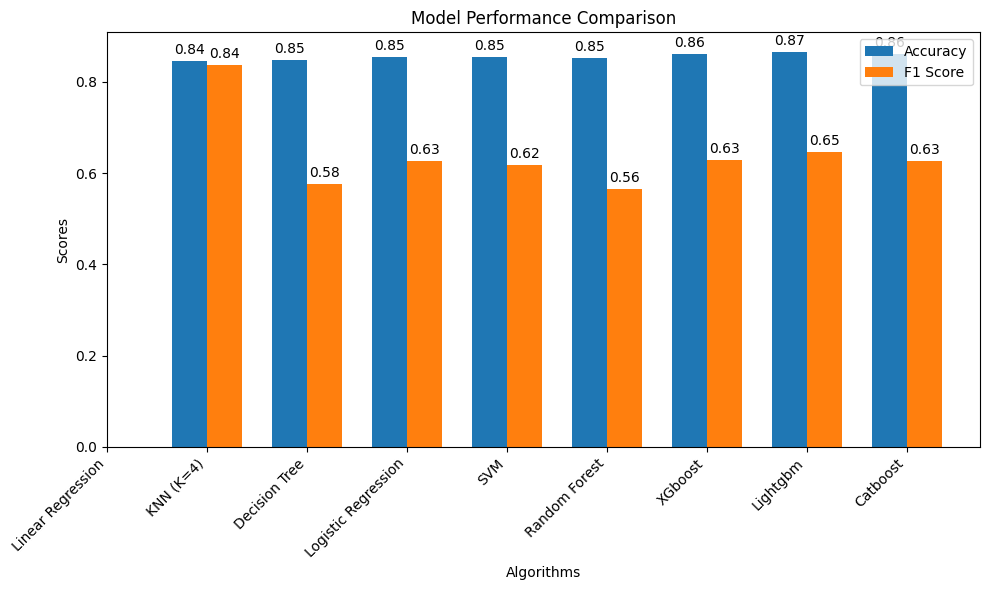

In [63]:
print("\nPlotting the Results...")
def plot_results(report):
    algorithms = report['Classification Algorithm']
    accuracy = report['Accuracy Score']
    f1_scores = report['F1 Score']

    x = np.arange(len(algorithms))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms, rotation=45, ha='right')
    ax.legend()

    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_results(Report_df)